In [40]:
%load_ext autoreload
%autoreload 2

from transformer_lens import HookedTransformer
import torch
from datasets import load_dataset

from tinystories_grads_jacob_utils import collect_gradients, plot_umap_with_hover

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
model = HookedTransformer.from_pretrained("tiny-stories-1M", dtype="bfloat16", device="cuda")
dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)

Loaded pretrained model tiny-stories-1M into HookedTransformer


In [52]:
# 2. Set parameters for gradient collection
layer_to_inspect = 3
batch_size = 256 # Adjust based on your GPU memory
num_tokens_to_collect = 100_000 
print_frequency = 10 # Print memory usage every batch

# 3. Collect gradients
gradients, hover_texts, tokens = collect_gradients(
    model=model,
    dataset=dataset,
    layer=layer_to_inspect,
    batch_size=batch_size,
    n_tokens_to_collect=num_tokens_to_collect,
    print_freq=print_frequency,
    max_seq_len=128,
    hover_context_chars=40
)

# 4. Inspect the result
print(f"\nShape of  gradients before flattening: {gradients.shape}")

gradients = gradients.reshape(-1, gradients.shape[-1])

print(f"\nShape of collected gradients after flattening: {gradients.shape}")


Finished. Collected gradients for 100000 tokens.
Final CPU Memory Usage: 62.20 GB

Shape of  gradients before flattening: torch.Size([100000, 64])

Shape of collected gradients after flattening: torch.Size([100000, 64])


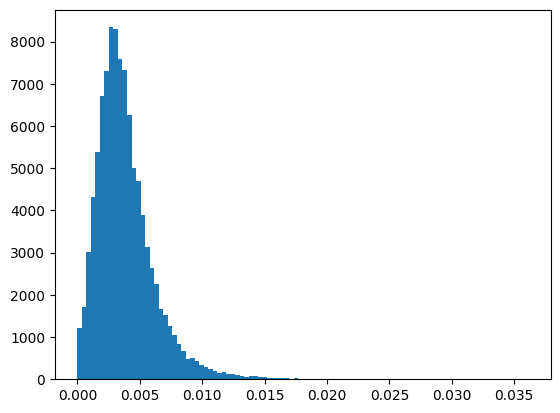

In [79]:
norms = gradients.norm(dim=1)

import matplotlib.pyplot as plt
plt.hist(norms.float().cpu().detach(), bins=100)
plt.show()

is_large = norms > norms.float().quantile(0.9)

In [83]:
every_k = 1
plot_umap_with_hover(
    data=gradients[is_large][::every_k],
    hover_texts=[hover_texts[i] for i in range(len(hover_texts)) if is_large[i]][::every_k],
    tokens=tokens[is_large][::every_k],  # Pass tokens for color-coding
    title=f"UMAP of Gradients from Layer {layer_to_inspect}",
    n_neighbors=15,
    min_dist=0.2,
    opacity=0.2
)

Running UMAP...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Creating plot...
